# 로그분석

## DATA import

In [358]:
import glob
import gzip
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import mysql.connector
plt.rcParams['font.family'] = 'NanumGothic'
pd.set_option('display.max.colwidth', 1000)

pattern = r"\[(.*?)\] \[(.*?)\]: (.*)"
file_list = glob.glob('log/*.gz')
data = []
for file in file_list:
    with gzip.open(file, 'rb') as f:
        log_data = f.read().decode('utf-8')
        groups = re.findall(pattern, log_data)
        for group in groups:
            data.append(group)

db = # 정보
cursor = db.cursor()
query = 'SELECT name FROM player_info_view'
cursor.execute(query)
rows = cursor.fetchall()
user_df = pd.DataFrame(rows, columns=['Username'])
lst = list(user_df['Username'].values)
        
df = pd.DataFrame(data, columns=['Timestamp', 'Level', 'Message'])
df = df[~df['Message'].str.contains('청소')] # 청소 관련 처리 
dd = df[['Timestamp','Message']]
dd

,Timestamp,Message
0,08:11:19,You specified a resource pack without providing a sha1 hash. Pack will be updated on the client only if you change the name of the pack.
1,08:11:20,"Environment: Environment[accountsHost=https://api.mojang.com, sessionHost=https://sessionserver.mojang.com, servicesHost=https://api.minecraftservices.com, name=PROD]"
2,08:11:23,Loaded 1174 recipes
3,08:11:24,Loaded 1271 advancements
4,08:11:24,Starting minecraft server version 1.20.2
...,...,...
44334,03:55:07,ThreadedAnvilChunkStorage (DIM1): All chunks are saved
44335,03:55:07,ThreadedAnvilChunkStorage: All dimensions are saved
44336,03:55:07,Flushing Chunk IO
44337,03:55:07,Closing Thread Pool


## 접속 분석

In [359]:
df[df['Message'].str.contains('[+]')]['Message'].value_counts()

Message
[+]  [뉴비] kjs04               62
[+]  [뉴비] taegyu08            38
[+]  kjs04 님이 서버에 접속했습니다 !    36
[+]  Elvaaaaaaaa              33
[+]  [뉴비] KDG_04              31
                              ..
[+]  yebibibibibib             1
[+]  msnxxo                    1
[+]  mno8901                   1
[+]  ktshkt2820                1
[+]  Min___E                   1
Name: count, Length: 205, dtype: int64

### 가장 많이 접속한 유저

In [360]:
lst[0:5]

['02tu', '0c0samoo', '12321', '1hxojxn', '1qa8z76']

In [361]:
dd[(dd['Message'].str.contains('\[\+\].*kjs04.*'))]


,Timestamp,Message
3351,09:34:50,[+] kjs04 님이 서버에 접속했습니다 !
3372,10:01:35,[+] kjs04 님이 서버에 접속했습니다 !
3378,10:07:30,[+] kjs04 님이 서버에 접속했습니다 !
3445,11:04:29,[+] kjs04 님이 서버에 접속했습니다 !
3676,12:44:00,[+] kjs04 님이 서버에 접속했습니다 !
...,...,...
37528,23:27:43,[+] [뉴비] kjs04
39310,16:15:38,[+] [뉴비] kjs04
39625,23:10:14,[+] [뉴비] kjs04
39639,00:45:23,[+] [뉴비] kjs04


In [411]:
import datetime
def convert_to_seconds(timestamp):
    time_obj = datetime.datetime.strptime(timestamp, '%H:%M:%S')
    seconds = time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
    # 새벽 시간 (00:00:00 ~ 06:00:00) 처리
    if time_obj.hour < 6:
        seconds += 86400
    return seconds

d_login = dd[(dd['Message'].str.contains('\[\+\].*')) | (dd['Message'].str.contains('\[\-\].*'))]
d_login = d_login[~d_login['Message'].str.contains('님이')].reset_index().drop(['index'],axis=1)
d_login['Seconds'] = d_login['Timestamp'].apply(convert_to_seconds)
d_login

,Timestamp,Message,Seconds
0,12:56:08,[-] [뉴비]kjs04,46568
1,12:56:17,[+] [뉴비]kjs04,46577
2,12:56:30,[-] ◎OP◎Loitec1114,46590
3,12:56:41,[+] ◎OP◎Loitec1114,46601
4,12:57:48,[-] [뉴비]kjs04,46668
...,...,...,...
898,00:47:50,[-] [뉴비] kjs04,89270
899,01:05:15,[+] [뉴비] kjs04,90315
900,01:05:49,[+] [뉴비] KDG_04,90349
901,01:41:36,[-] [뉴비] kjs04,92496


In [363]:
lst[0:5]

['02tu', '0c0samoo', '12321', '1hxojxn', '1qa8z76']

In [365]:
# gpt 코드
user_times = {}

for user in lst:
    user_messages = d_login[d_login['Message'].str.contains(user)]
    plus_indices = user_messages[user_messages['Message'].str.contains('\[\+\]')].index
    minus_indices = user_messages[user_messages['Message'].str.contains('\[-\]')].index

    cumulative_time = 0
    for i in range(len(plus_indices)):
        if i < len(minus_indices):
            login_time = user_messages.loc[plus_indices[i], 'Seconds']
            logout_time = user_messages.loc[minus_indices[i], 'Seconds']
            time_diff = logout_time - login_time
            cumulative_time += time_diff
    user_times[user] = cumulative_time

print(user_times)

{'02tu': 309, '0c0samoo': 8799, '12321': 0, '1hxojxn': 124, '1qa8z76': 93, '21singularity': 69, '5sYeon': 464, '6gaejang_22': 3682, 'akosih44': 2066, 'anaud12': 553, 'angryjin': 231, 'Anung_': 973, 'apple_kor': 4117, 'arang': 0, 'Arangcho': -82264, 'bangbong0': 14, 'biracksickhye': 71980, 'blackggami': 0, 'black_789': 56, 'BOKUNOFULLMOON': 3732, 'Carus0402': 0, 'celaduck': -80182, 'chans0504': 59, 'Chkida': 556, 'chlghtjd': 880, 'choiyj120730': 0, 'ChoonSik_2': 0, 'chuzzang': -87415, 'Ckum_': 247, 'clobby_1': 0, 'cn22e': 722, 'Croias': 632, 'cross_fie1d': 207, 'cubids': 0, 'danmak534': 45, 'Darkiran': 2851, 'dddd': 0, 'dddd1231': 0, 'Ddonghuhu': 0, 'dektembuel': 0, 'dkfkqldkdnjsxnf': 0, 'dkwhwTl': 0, 'dlehgud1128': 2, 'dnsuak2222': 0, 'Dohori': 8837, 'Dovep': 0, 'ducra0331': 0, 'Ectheo': 0, 'EEEAAASSSYYY': 409, 'ejfjwjdjw': 29, 'cheongna': 1586, 'fancyguy07': 967, 'fly64': 0, 'galaxy_wk': 47, 'Gang_Minsoi': 0, 'garakdubu': 766, 'gattina_': 803, 'ggm_chip': 343, 'GIHYEON1015': 0, 'gomy_

In [366]:
ele = lst.copy()
ele

['02tu',
 '0c0samoo',
 '12321',
 '1hxojxn',
 '1qa8z76',
 '21singularity',
 '5sYeon',
 '6gaejang_22',
 'akosih44',
 'anaud12',
 'angryjin',
 'Anung_',
 'apple_kor',
 'arang',
 'Arangcho',
 'bangbong0',
 'biracksickhye',
 'blackggami',
 'black_789',
 'BOKUNOFULLMOON',
 'Carus0402',
 'celaduck',
 'chans0504',
 'Chkida',
 'chlghtjd',
 'choiyj120730',
 'ChoonSik_2',
 'chuzzang',
 'Ckum_',
 'clobby_1',
 'cn22e',
 'Croias',
 'cross_fie1d',
 'cubids',
 'danmak534',
 'Darkiran',
 'dddd',
 'dddd1231',
 'Ddonghuhu',
 'dektembuel',
 'dkfkqldkdnjsxnf',
 'dkwhwTl',
 'dlehgud1128',
 'dnsuak2222',
 'Dohori',
 'Dovep',
 'ducra0331',
 'Ectheo',
 'EEEAAASSSYYY',
 'ejfjwjdjw',
 'cheongna',
 'fancyguy07',
 'fly64',
 'galaxy_wk',
 'Gang_Minsoi',
 'garakdubu',
 'gattina_',
 'ggm_chip',
 'GIHYEON1015',
 'gomy_ammi',
 'Goommm',
 'gusrb0607',
 'HaimPokey',
 'hanu02',
 'happyerred',
 'Hate__MySelf',
 'He_rok',
 'He__se',
 'Hnxa2004',
 'HODORY',
 'hogu1111',
 'HoJeong',
 'hoyeonn_n',
 'hyeo_k08',
 'Hyungoo',
 'hy

In [373]:
# 개수가 일치하지 않은것 날리는 방법(1)
time = []
for li in ele:
    plus = []
    minus = []
    for idx, message in enumerate(d_login['Message']):
        if (li in message) and ('[+]' in message):
            plus.append(d_login.iloc[idx]['Seconds'])
        elif (li in message) and ('[-]' in message):
            minus.append(d_login.iloc[idx]['Seconds'])

    # [+] 개수와 [-] 개수가 같은지 확인
    if len(plus) == len(minus):
        total_plus_time = sum(plus)
        total_minus_time = sum(minus)
        result = total_minus_time - total_plus_time
        time.append(result)
    else:
        print(f"사용자 '{li}'의 [+] 개수와 [-] 개수가 일치하지 않습니다.")
        ele.remove(li)
    
df_time = pd.DataFrame({'User': ele, '누적초': time})
df_time.sort_values(by='누적초',ascending=False)

191
191


,User,누적초
16,biracksickhye,71980
63,hanu02,42867
128,Nangman1999,36250
135,pm0813,17468
142,Raspberrysb,11698
...,...,...
14,Arangcho,-82264
27,chuzzang,-87415
165,taegyu08,-338362
178,wooin04301,-351661


In [ ]:
#최종
import datetime
def convert_to_seconds(timestamp):
    time_obj = datetime.datetime.strptime(timestamp, '%H:%M:%S')
    seconds = time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
    # 새벽 시간 (00:00:00 ~ 06:00:00) 처리
    if time_obj.hour < 6:
        seconds += 86400
    return seconds

d_login = dd[(dd['Message'].str.contains('\[\+\].*')) | (dd['Message'].str.contains('\[\-\].*'))]
d_login = d_login[~d_login['Message'].str.contains('님이')].reset_index().drop(['index'],axis=1)
d_login['Seconds'] = d_login['Timestamp'].apply(convert_to_seconds)


# 개수 일치하는거 처리하는 방법(2)
# d_login = d_login.drop([0, 2, 610]) # 인덱스 날려버리기 
time = []
# no_match =[]
for li in lst:
    plus = []
    minus = []
    for idx, message in enumerate(d_login['Message']):
        if (li in message) and ('[+]' in message):
            plus.append(d_login.iloc[idx]['Seconds'])
        elif (li in message) and ('[-]' in message):
            minus.append(d_login.iloc[idx]['Seconds'])

    # [+] 개수와 [-] 개수가 같은지 확인
    if len(plus) == len(minus):
        total_plus_time = sum(plus)
        total_minus_time = sum(minus)
        result = total_minus_time - total_plus_time
        time.append(result/3600)
    else:
        print(f"사용자 '{li}'의 [+] 개수와 [-] 개수가 일치하지 않습니다. plus 개수 : {len(plus)} , minus 개수 : {len(minus)}")
        # no_match.append(li)


# print(no_match) # 매치안된거 확인(['KDG_04(610인덱스 날리자)'/'kjs04(0번인덱스 날리자)'/'Loitec1114(2번인덱스 날리자)']_
# 확인#
# print(len(lst))
# print(len(time))
df_time = pd.DataFrame({'User': lst , '누적 시간': time}).sort_values(by='누적 시간',ascending=False).reset_index().drop('index',axis=1).head(10)
df_time

In [ ]:
def user_logit(df,lst):
    extracted = []
    for message in d_login['Message']:
        for ltem in lst:
            if ltem in message:
                extracted.append(ltem)
                break
        else:
            extracted.append(' ')
    df['user'] = extracted 

C:\Users\administ\ipykernel_23660\232803862.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index, y=top_users.values, palette='viridis')


Text(0.5, 1.0, '유저별 접속횟수')

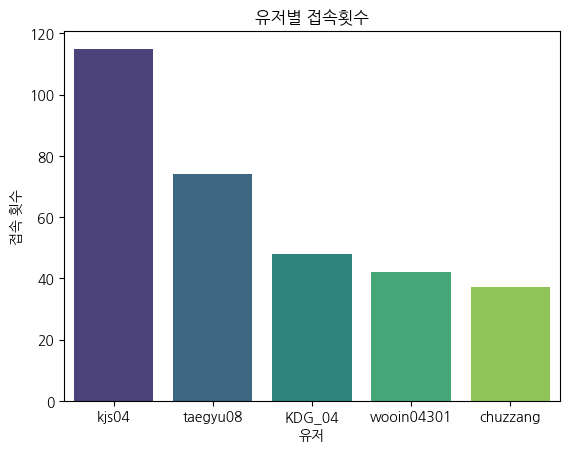

In [ ]:
top_users = d_login['Message'].str.extract(r'\[\w+\] ?(\w+)')[0].value_counts().head(5) # 뉴비 뒤에있는 문자추출
sns.barplot(x=top_users.index, y=top_users.values, palette='viridis')
plt.xlabel('유저')
plt.ylabel('접속 횟수')
plt.title('유저별 접속횟수')

## 구입 분석 (구입은 gui밖에 없다)

### 데이터 전처리

In [ ]:
df_buy = dd[dd['Message'].str.contains('구입')].copy()
df_buy['Item'] = df_buy['Message'].str.extract(r'님이 ([^(]+)') # 님이 이후에 괄호를 뺀 모든 문자열
df_buy['Count'] = df_buy['Message'].str.extract(r'(\d+) 만큼') # 숫자 , 만큼 
df_buy['cost'] = df_buy['Message'].str.extract(r'(\d+)를') 
df_buy['Count'] = df_buy['Count'].astype(int)
df_buy['cost'] = df_buy['cost'].astype(int)
df_buy["category"] = df_buy["Message"].str.findall(r"\((.+?)\.")
df_buy["category"] = df_buy["category"].apply(lambda x: ', '.join(x))
df_buy

,Timestamp,Message,Item,Count,cost,category
2852,00:52:02,Shop >> Install_Roblox 님이 Bone(Mobs.page1.items.4)를 13 만큼 195를 지불해 구입 화면로 구입 하셨습니다.,Bone,13,195,Mobs
3440,10:50:47,Shop >> kjs04 님이 Potato(Farming.page1.items.21)를 17 만큼 85를 지불해 구입 화면로 구입 하셨습니다.,Potato,17,85,Farming
3694,12:56:50,Shop >> kjs04 님이 Warped Slab(Blocks.page5.items.220)를 33 만큼 9.24를 지불해 구입 화면로 구입 하셨습니다.,Warped Slab,33,24,Blocks
3722,13:12:27,Shop >> Install_Roblox 님이 Cobblestone(Blocks.page2.items.54)를 128 만큼 87.04를 지불해 세트 구매 화면로 구입 하셨습니다.,Cobblestone,128,4,Blocks
3728,13:13:11,Shop >> Install_Roblox 님이 Birch Log(Blocks.page4.items.175)를 64 만큼 192를 지불해 세트 구매 화면로 구입 하셨습니다.,Birch Log,64,192,Blocks
...,...,...,...,...,...,...
32601,23:12:16,Shop >> KDG_04 님이 Iron Ingot(Ores.page1.items.16)를 2 만큼 160를 지불해 구입 화면로 구입 하셨습니다.,Iron Ingot,2,160,Ores
32643,23:32:26,"Shop >> wooin04301 님이 Coal Block(Ores.page1.items.5)를 17 만큼 2,720를 지불해 구입 화면로 구입 하셨습니다.",Coal Block,17,720,Ores
32658,23:36:25,Shop >> taegyu08 님이 Glass(Blocks.page3.items.112)를 1 만큼 6.30를 지불해 구입 화면로 구입 하셨습니다.,Glass,1,30,Blocks
32660,23:36:44,Shop >> taegyu08 님이 Glass(Blocks.page3.items.112)를 1 만큼 6.30를 지불해 구입 화면로 구입 하셨습니다.,Glass,1,30,Blocks


### 그래프

C:\Users\administ\ipykernel_23660\4027194075.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_item_total.index, y=top_item_total.values, ax=axes[0], palette='viridis')
C:\Users\administ\ipykernel_23660\4027194075.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_item_count.index, y=top_item_count.values, ax=axes[1], palette='viridis')
C:\Users\administ\ipykernel_23660\4027194075.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_item_category.index, y=top_item_category.values, ax=axes[2], palette='viridis')


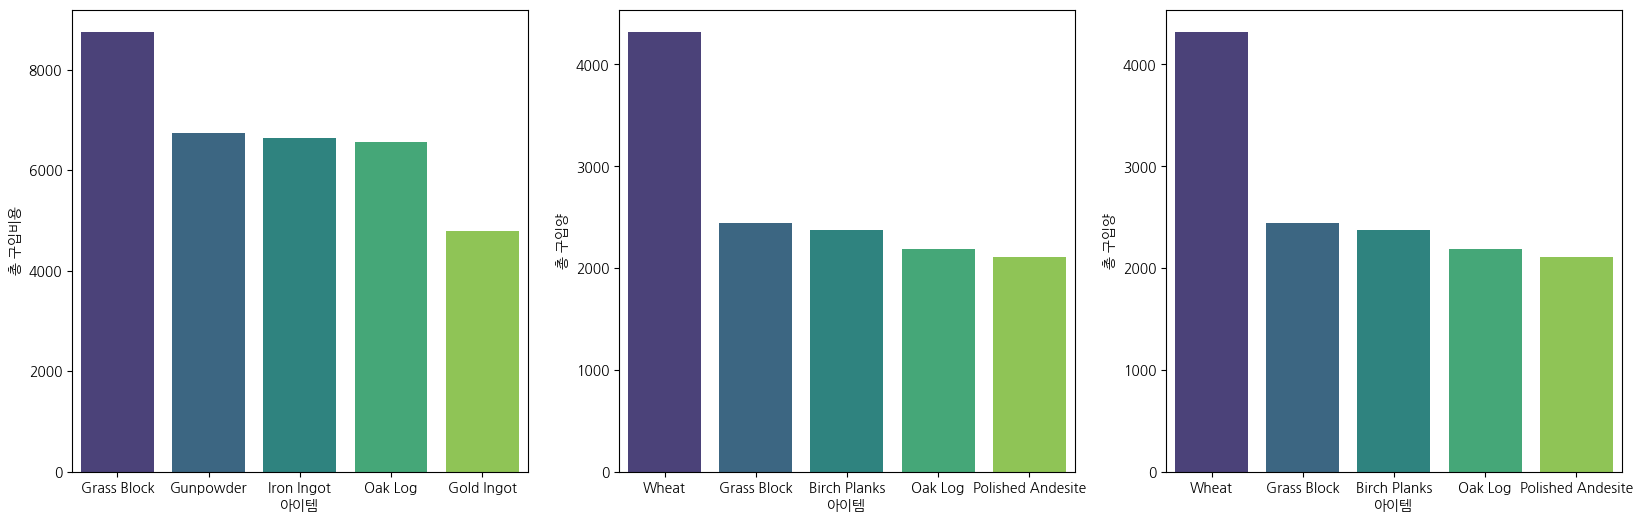

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# 첫 번째 그래프: 총 비용
top_item_total = df_buy.groupby('Item')['cost'].sum().sort_values(ascending=False).head(5)
sns.barplot(x=top_item_total.index, y=top_item_total.values, ax=axes[0], palette='viridis')
axes[0].set_xlabel('아이템')
axes[0].set_ylabel('총 구입비용')

# 두 번째 그래프: 아이템별 총 구입량 
top_item_count = df_buy.groupby('Item')['Count'].sum().sort_values(ascending=False).head(5)
sns.barplot(x=top_item_count.index, y=top_item_count.values, ax=axes[1], palette='viridis')
axes[1].set_xlabel('아이템')
axes[1].set_ylabel('총 구입양')

top_item_category = df_buy.groupby('Item')['Count'].sum().sort_values(ascending=False).head(5)
sns.barplot(x=top_item_category.index, y=top_item_category.values, ax=axes[2], palette='viridis')
axes[2].set_xlabel('아이템')
axes[2].set_ylabel('총 구입양')


plt.show()

## 판매 분석(gui랑 shop으로 판매 나눠짐)

### 데이터 전처리(gui->df_sell1)

In [ ]:
# gui
df_sell1 = dd[dd['Message'].str.contains('판매 gui')]
df_sell1 = df_sell1[~df_sell1['Message'].str.contains('챗')]
df_sell1['item'] = df_sell1['Message'].str.extractall(r'(\d+x\s([\w\s]+)\(.*?\))')[1].groupby(level=0).apply(list)
df_sell1['item'] = df_sell1['item'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df_sell1['cost'] = df_sell1['Message'].str.extract(r'for (\d{1,3}(?:,\d{3})*(?:\.\d+)?)')
df_sell1['cost'] = df_sell1['cost'].str.replace(',', '').astype(float)
df_sell1["category"] = df_sell1["Message"].str.findall(r"\((.+?)\.")
df_sell1["category"] = df_sell1["category"].apply(lambda x: ', '.join(x))
df_sell1.head(5)

,Timestamp,Message,item,cost,category
2714,00:04:54,Shop >> bangbong0 판매 21x Copper Ingot(Ores.page1.items.7) for 147 with the 판매 gui.,Copper Ingot,147.00,Ores
2716,00:08:05,"Shop >> Install_Roblox 판매 39x Cobbled Deepslate(Blocks.page2.items.89), 63x Redstone(Ores.page1.items.23), 1x Tuff(Blocks.page1.items.12), 7x Rotten Flesh(Mobs.page1.items.15), 3x Gunpowder(Mobs.page1.items.8) for 332.13 with the 판매 gui.","Cobbled Deepslate, Redstone, Tuff, Rotten Flesh, Gunpowder",332.13,"Blocks, Ores, Blocks, Mobs, Mobs"
2718,00:08:18,"Shop >> bangbong0 판매 2x Arrow(Mobs.page1.items.1), 41x Copper Ingot(Ores.page1.items.7) for 287.60 with the 판매 gui.","Arrow, Copper Ingot",287.60,"Mobs, Ores"
2721,00:08:27,Shop >> bangbong0 판매 20x Glow Berries(Food.page1.items.20) for 4 with the 판매 gui.,Glow Berries,4.00,Food
2723,00:12:56,"Shop >> Install_Roblox 판매 158x Cobbled Deepslate(Blocks.page2.items.89), 1x Redstone(Ores.page1.items.23), 37x Tuff(Blocks.page1.items.12) for 50.36 with the 판매 gui.","Cobbled Deepslate, Redstone, Tuff",50.36,"Blocks, Ores, Blocks"


### 데이터전처리(shop->df_sell2)

In [ ]:
# 하나 판매
df_sell2 = dd[dd['Message'].str.contains('판매 하셨습니다')].copy()
df_sell2['item'] = df_sell2['Message'].str.extract(r'님이 ([^(]+)')
df_sell2['cost'] = df_sell2['Message'].str.extract(r'(\d+)를') 
df_sell2['cost'] = df_sell2['cost'].astype(float)
df_sell2["category"] = df_sell2["Message"].str.findall(r"\((.+?)\.")
df_sell2["category"] = df_sell2["category"].apply(lambda x: ', '.join(x))
df_sell2.head(5)

,Timestamp,Message,item,cost,category
4246,16:04:38,Shop >> Kr_jmlo20 님이 Rotten Flesh(Mobs.page1.items.15)를 3 만큼 3를 지불해 quick sell screen로 판매 하셨습니다.,Rotten Flesh,3.0,Mobs
4261,16:07:48,"Shop >> Rare_fruit 님이 Netherite Ingot(Ores.page1.items.20)를 1 만큼 45,000를 지불해 판매 화면로 판매 하셨습니다.",Netherite Ingot,0.0,Ores
4306,16:18:20,"Shop >> Kr_jmlo20 님이 Diamond(Ores.page1.items.9)를 38 만큼 7,600를 지불해 quick sell screen로 판매 하셨습니다.",Diamond,600.0,Ores
5509,21:19:56,Shop >> dddd1231 님이 Emerald Block(Ores.page1.items.12)를 1 만큼 500를 지불해 판매 화면로 판매 하셨습니다.,Emerald Block,500.0,Ores
5511,21:19:56,Shop >> dddd1231 님이 Emerald Block(Ores.page1.items.12)를 1 만큼 500를 지불해 판매 화면로 판매 하셨습니다.,Emerald Block,500.0,Ores


### 판매 다양한 분석

In [ ]:
# 조합 최고 돈번 상품 
df_sell1.groupby('item')['cost'].sum().sort_values(ascending=False).head(5) 

item
Netherite Block                                                        3600000.00
Netherite Ingot                                                        1665000.00
Netherite Ingot, Quartz                                                 720705.00
Basalt, Magma Block, Netherrack, Gravel, Ancient Debris, Blackstone     582812.14
Emerald Block                                                           369000.00
Name: cost, dtype: float64

In [ ]:
# 한개만 캐서 파는 최고 상품 
df_sell2.groupby('item')['cost'].sum().sort_values(ascending=False).head(5)

item
Emerald Block     24500.0
Diamond            7800.0
Redstone           5355.0
Copper Block       4680.0
Redstone Block     4100.0
Name: cost, dtype: float64

### 시각화

C:\Users\administ\ipykernel_23660\2735251316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_item_sell_total.index, y=top_item_sell_total.values, ax=axes[0], palette='viridis')
C:\Users\administ\ipykernel_23660\2735251316.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_item_sell_total2.index, y=top_item_sell_total2.values, ax=axes[1], palette='viridis')


Text(0.5, 1.0, '개별 판매금액 총액')

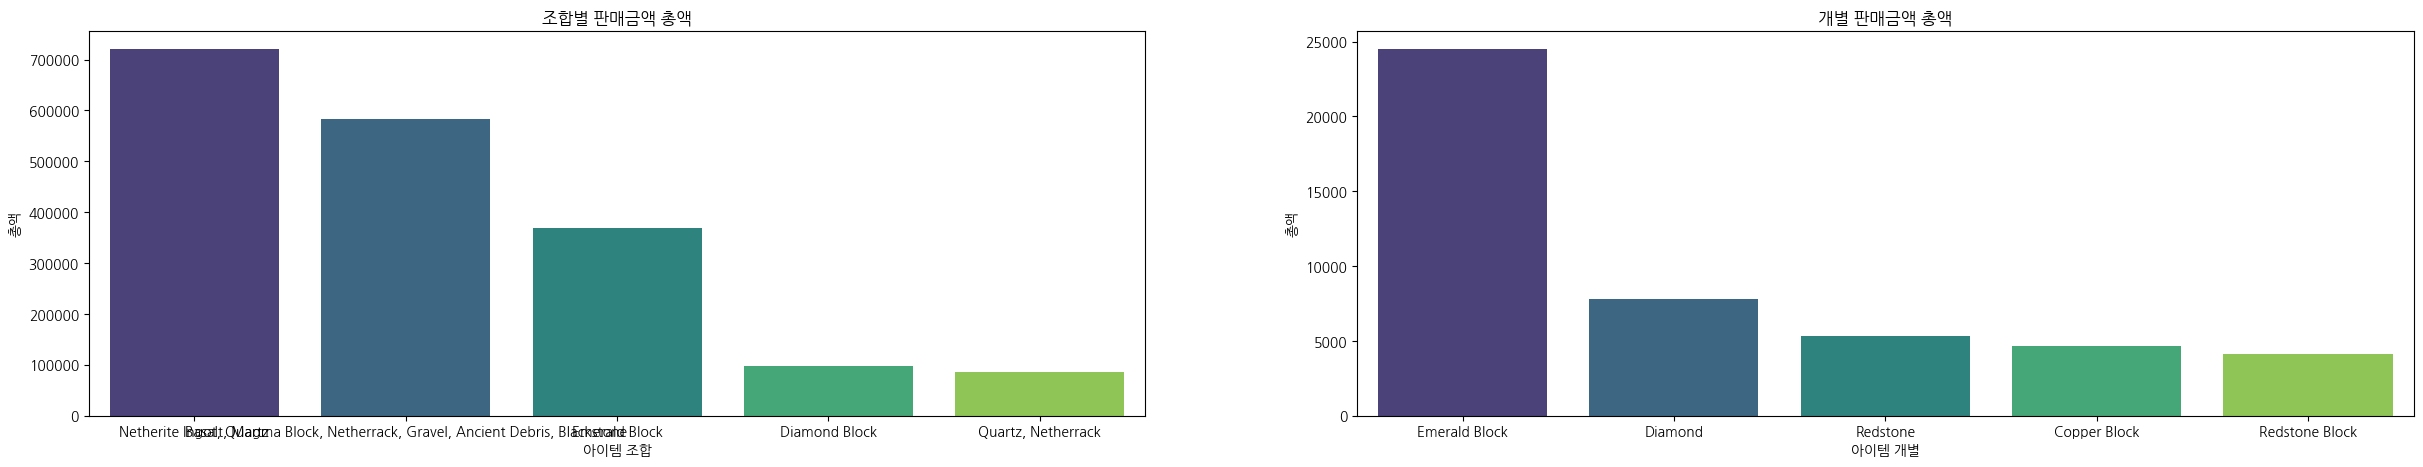

In [ ]:
# 고수들이 버는 돈

fig, axes = plt.subplots(1, 2, figsize=(30, 5))
# 첫 번째 그래프: 총 비용
top_item_sell_total = df_sell1.groupby('item')['cost'].sum().sort_values(ascending=False).iloc[2:7]
sns.barplot(x=top_item_sell_total.index, y=top_item_sell_total.values, ax=axes[0], palette='viridis')
axes[0].set_xlabel('아이템 조합')
axes[0].set_ylabel('총액')
axes[0].set_title('조합별 판매금액 총액')

# 두 번째 그래프: 총 개수
top_item_sell_total2 = df_sell2.groupby('item')['cost'].sum().sort_values(ascending=False).head(5)
sns.barplot(x=top_item_sell_total2.index, y=top_item_sell_total2.values, ax=axes[1], palette='viridis')
axes[1].set_xlabel('아이템 개별')
axes[1].set_ylabel('총액')
axes[1].set_title('개별 판매금액 총액')




### 판매 합쳐서

In [ ]:
df_sell = pd.concat([df_sell1,df_sell2])
df_sell['Message']

2714                                                                                                                                                                Shop >> bangbong0 판매 21x Copper Ingot(Ores.page1.items.7) for 147 with the 판매 gui.
2716     Shop >> Install_Roblox 판매 39x Cobbled Deepslate(Blocks.page2.items.89), 63x Redstone(Ores.page1.items.23), 1x Tuff(Blocks.page1.items.12), 7x Rotten Flesh(Mobs.page1.items.15), 3x Gunpowder(Mobs.page1.items.8) for 332.13 with the 판매 gui.
2718                                                                                                                               Shop >> bangbong0 판매 2x Arrow(Mobs.page1.items.1), 41x Copper Ingot(Ores.page1.items.7) for 287.60 with the 판매 gui.
2721                                                                                                                                                                 Shop >> bangbong0 판매 20x Glow Berries(Food.page1.items.20) for 4 with the 판매 gui.
2723        

In [ ]:
df_sell['item'] = df_sell['item'].str.replace(',\s*', ',', regex=True)
df_sell['category'] = df_sell['category'].str.replace(',\s*', ',', regex=True)

In [ ]:
# 유저들이 가장 많이 판매하는 상품 
all_words = ",".join(df_sell["item"])
word_counts = Counter(all_words.split(','))
sell_count =  word_counts.most_common(10)
sell_count_data = pd.DataFrame(sell_count, columns=['품목', '판매량'])
sell_count_data

,품목,판매량
0,Cobbled Deepslate,102
1,Netherrack,89
2,Quartz,72
3,Rotten Flesh,70
4,Cobblestone,66
5,Gravel,63
6,Emerald Block,63
7,Tuff,62
8,Wheat,62
9,Redstone,61


In [ ]:
# 카테고리별 가장 많이 팔리는 상품
all_words = ",".join(df_sell["category"])
word_counts = Counter(all_words.split(','))
sell_count =  word_counts.most_common(10)
sell_count_data = pd.DataFrame(sell_count, columns=['카테고리', '판매량'])
sell_count_data

,카테고리,판매량
0,Blocks,722
1,Ores,548
2,Farming,241
3,Mobs,177
4,Food,38


## 채팅 분석

In [ ]:
df_chat = df[df['Level'].str.contains('Async Chat Thread')]
df_chat['Level'].value_counts()

Level
Async Chat Thread - #90/INFO     183
Async Chat Thread - #39/INFO     105
Async Chat Thread - #110/INFO    101
Async Chat Thread - #96/INFO      83
Async Chat Thread - #111/INFO     81
                                ... 
Async Chat Thread - #151/INFO      1
Async Chat Thread - #144/INFO      1
Async Chat Thread - #142/INFO      1
Async Chat Thread - #140/INFO      1
Async Chat Thread - #123/INFO      1
Name: count, Length: 168, dtype: int64

In [ ]:
def user_logit(df,lst):
    extracted = []
    for message in df['Message']:
        for ltem in lst:
            if ltem in message:
                extracted.append(ltem)
                break
        else:
            extracted.append(' ')
    df['user'] = extracted 
user_logit(df_chat,lst)

In [ ]:
top_chat = df_chat['user'].value_counts().head(5) # 채팅 순위

user
Loitec1114       1345
WUSUCK            782
kjs04             257
KDG_04            244
biracksickhye     198
Name: count, dtype: int64

In [ ]:
df_chat_new = df_chat[df_chat['Message'].str.contains('[뉴비]')]  
top_chat_new = df_chat_new['user'].value_counts().head(5) # 뉴비 채팅 순위

user
Loitec1114       750
WUSUCK           745
kjs04            257
KDG_04           244
biracksickhye    181
Name: count, dtype: int64

## 유저 분석

In [ ]:
user_logit(df_buy,lst)
user_logit(df_sell,lst)

In [ ]:
df_buy.head()

,Timestamp,Message,Item,Count,cost,category,user
2852,00:52:02,Shop >> Install_Roblox 님이 Bone(Mobs.page1.items.4)를 13 만큼 195를 지불해 구입 화면로 구입 하셨습니다.,Bone,13,195,Mobs,Install_Roblox
3440,10:50:47,Shop >> kjs04 님이 Potato(Farming.page1.items.21)를 17 만큼 85를 지불해 구입 화면로 구입 하셨습니다.,Potato,17,85,Farming,kjs04
3694,12:56:50,Shop >> kjs04 님이 Warped Slab(Blocks.page5.items.220)를 33 만큼 9.24를 지불해 구입 화면로 구입 하셨습니다.,Warped Slab,33,24,Blocks,kjs04
3722,13:12:27,Shop >> Install_Roblox 님이 Cobblestone(Blocks.page2.items.54)를 128 만큼 87.04를 지불해 세트 구매 화면로 구입 하셨습니다.,Cobblestone,128,4,Blocks,Install_Roblox
3728,13:13:11,Shop >> Install_Roblox 님이 Birch Log(Blocks.page4.items.175)를 64 만큼 192를 지불해 세트 구매 화면로 구입 하셨습니다.,Birch Log,64,192,Blocks,Install_Roblox


In [ ]:
df_buy.groupby('user')['cost'].sum().sort_values(ascending=False).head(5) # 유저 구매왕 

user
KDG_04        33922
taegyu08      15743
hoyeonn_n      9331
kjs04          8984
wooin04301     3004
Name: cost, dtype: int32

In [ ]:
df_buy.groupby('user')['Count'].sum().sort_values(ascending=False).head(5) # 유저별 구매상품 개수 순위 

user
KDG_04       13660
taegyu08      4761
lmmjvs_       4472
hoyeonn_n     2318
kjs04         1967
Name: Count, dtype: int32

In [ ]:
df_buy.groupby(['user','category'])['Count'].sum().sort_values(ascending=False).head(10) # 유저별 카테고리 상품을 많이 샀는지 

user        category
KDG_04      Blocks      12423
lmmjvs_     Farming      4288
taegyu08    Blocks       3929
WUSUCK      Blocks       1896
hoyeonn_n   Blocks       1761
Rare_fruit  Blocks       1600
kjs04       Blocks       1561
wooin04301  Blocks       1275
KDG_04      Mobs          512
            Ores          511
Name: Count, dtype: int32

In [ ]:
df_buy.groupby(['user','Item'])['Count'].sum().sort_values(ascending=False).head(10) # 유저별 어떤 아이템을 많이 샀는지 

user        Item                 
lmmjvs_     Wheat                    4288
KDG_04      Grass Block              2182
            Polished Andesite        2112
            Light Gray Concrete      1344
WUSUCK      Birch Planks             1313
Rare_fruit  Polished Granite Slab    1280
taegyu08    White Concrete           1088
            Stone                    1042
hoyeonn_n   Dark Oak Log              838
            Oak Log                   706
Name: Count, dtype: int32

In [ ]:
df_sell.groupby('user')['cost'].sum().sort_values(ascending=False).head(5) # 유저 판매왕

user
kjs04              5370751.55
KDG_04             1414564.91
                    501504.94
dkfkqldkdnjsxnf     252000.00
dddd                124500.00
Name: cost, dtype: float64

In [ ]:
df_sell.groupby(['item','user'])['user'].count().sort_values(ascending=False).head(5) # 아이템별 어떤 유저가 많이 팔았는지

item               user    
Copper Block                   36
Emerald Block      dkwhwTl     36
Cobbled Deepslate              35
Wheat              taegyu08    27
Redstone Block                 23
Name: user, dtype: int64

In [ ]:
df_sell.groupby(['category','user'])['user'].count().sort_values(ascending=False).head(5)

category  user    
Blocks                129
Ores                  113
          taegyu08     81
          dkwhwTl      36
Farming   taegyu08     31
Name: user, dtype: int64

## 에러분석

In [ ]:
df[df['Level']=='Server thread/WARN']['Message'].value_counts()

Message
kjs04 moved wrongly!                                                                                                                                    161
TEST 1 200.0 - 10.0                                                                                                                                      26
[!] The timings profiler has been enabled but has been scheduled for removal from Paper in the future.                                                   15
[org.bukkit.craftbukkit.v1_20_R2.legacy.CraftLegacy] Initializing Legacy Material Support. Unless you have legacy plugins and/or data this is a bug!     15
Legacy plugin DiscordBot v2.0 does not specify an api-version.                                                                                           14
                                                                                                                                                       ... 
wooin04301 moved too quickly! 263.37488196073264,15.0,32

In [ ]:
df[df['Message'].str.contains('Towny')]

,Timestamp,Level,Message
88,08:14:55,Server thread/INFO,[Towny] Loading server plugin Towny v0.100.0.0
98,08:14:57,Server thread/INFO,[TownyChat] Loading server plugin TownyChat v0.109
112,08:14:58,Server thread/INFO,[Dynmap-Towny] Loading server plugin Dynmap-Towny v0.97
170,08:15:08,Server thread/INFO,[Towny] Enabling Towny v0.100.0.0
171,08:15:08,Server thread/INFO,==================== Towny ========================
...,...,...,...
30221,14:33:58,Folia Async Scheduler Thread #287/INFO,[Towny] [Town Msg] tanker: chuzzang님이 2000원을/를 마을 은행으로 입금했습니다.
30302,14:48:26,Folia Async Scheduler Thread #293/INFO,[Towny] [Town Msg] tanker: chuzzang님이 500원을/를 마을 은행으로 입금했습니다.
32007,22:03:40,Folia Async Scheduler Thread #524/INFO,[Towny] [Town Msg] 크리스탈: WUSUCK님이 300원을/를 마을 은행으로 입금했습니다.
32637,23:31:41,Server thread/INFO,[Towny] [Town Msg] 크리스탈: WUSUCK님이 Arangcho님을 도시에 초대하였습니다.


## 토픽 모델링을 위함